In [1]:
# important imports

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage

# STEP 1: RAW DATA

# Reading Table.txt to create dictionary mapping building numbers to names
buildings = dict()
f = open("Desktop/vis_int_hw3/Table.txt", "r")
#print(f.read())
for line in f:
    split_line = line.split()
    buildings[int(split_line[0])] = split_line[1]
f.close()
print(buildings)

{9: 'Pupin', 19: 'SchapiroCEPSR', 28: 'Mudd&EngTerrace&Fairchild&CS', 38: 'NorthwestCorner', 47: 'Uris', 57: 'Schermerhorn', 66: 'Chandler&Havemeyer', 76: 'OldComputerCenter', 85: 'Avery', 94: 'Fayerweather', 104: 'Mathematics', 113: 'LowLibrary', 123: 'StPaulChapel', 132: 'EarlHall', 142: 'Lewisohn', 151: 'Philosophy', 161: 'Buell', 170: 'AlmaMater', 179: 'Dodge', 189: 'Kent', 198: 'CollegeWalk', 208: 'Journalism&Furnald', 217: 'Hamilton&Hartley&Wallach&JohnJay', 236: 'Lerner', 246: 'ButlerLibrary', 255: 'Carman'}


In [2]:
# Creating Numpy Array from 'Labeled.pgm' file
labeled_file = Image.open('Desktop/vis_int_hw3/Labeled.pgm')
labeled_arr = np.asarray(labeled_file)
 
# <class 'numpy.ndarray'>
print(type(labeled_arr))
 
#  shape
print(labeled_arr.shape)

print(labeled_arr)

<class 'numpy.ndarray'>
(495, 275)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Area:  2615  | COM:  (30, 363)  | MBR:  ((4, 338), (81, 414), 108.2)


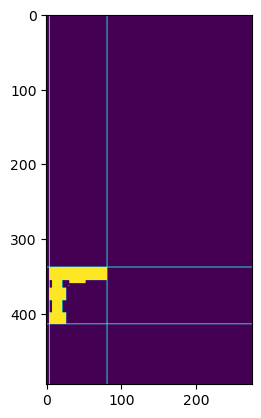

In [3]:
# NOTE: The center of mass calculation performed in this function using the ndimage was found
# from the following source:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html


# Function that creates a 2D numpy binary array where pixels with a 1 indicate the location of the 
# target building while 0's indicate all other pixels (including space between buildings and other buildings)
# This function also returns valuable information about the building including area in pixels, com, and mbr info
def building_layer_area_com_mbr(target_num, labeled_arr): 
    # target_num is int representing target building number 
    # labeled_arr is np array version of Labeled.pgm file
    # returns tuple of length four containing the following info:
        # 1: binary np array with same size as labeled_arr with 1's in locations where target building
            # pixels are located and 0's in all other locations
        # 2: total area in pixels
        # 3: tuple of size 2 containing (x,y) coords of target building Center of Mass
        # 4: tuple of size 3 containing (mbr upper left coordinate (x,y) tuple, 
        #                                mbr lower right coordinate (x,y) tuple, length of diagonal)
    layer = np.copy(labeled_arr)
    area = 0
    height = labeled_arr.shape[0]
    width = labeled_arr.shape[1]
    
    leftmost_x = width-1
    rightmost_x = 0
    lowermost_y = 0
    uppermost_y = height-1
    
    for row in range(height):
        for col in range(width):
            if labeled_arr[row,col] == target_num:
                layer[row,col] = 1
                
                area += 1
                
                rightmost_x = max(col, rightmost_x)
                leftmost_x = min(col, leftmost_x)
                uppermost_y = min(row, uppermost_y)
                lowermost_y = max(row, lowermost_y)
                
            else:
                layer[row,col] = 0
                
    nd_com = ndimage.center_of_mass(layer) # returns (row, col) not (x,y)
    x = int(nd_com[1])
    y = int(nd_com[0])
    #x = ((rightmost_x - leftmost_x)/2.0) + leftmost_x
    #y = ((lowermost_y - uppermost_y)/2.0) + uppermost_y
    com = (x,y)
    
    mbr_upperleft = (leftmost_x, uppermost_y)
    mbr_lowerright = (rightmost_x, lowermost_y)
    diag = round(math.dist(mbr_upperleft, mbr_lowerright), 1)
    mbr = (mbr_upperleft, mbr_lowerright, diag)
    
    return (layer, area, com, mbr)

# code that tests building_layer_area_com_mbr function by printing area and ploting the test building layer including
    # COM coord point and lines representing the MBR
    
test_target_num = 208

test = building_layer_area_com_mbr(test_target_num, labeled_arr)
test_layer = test[0]
test_area = test[1]
test_com = test[2]
test_mbr = test[3]
test_mbr_upperleftcorner = test_mbr[0]
test_mbr_lowerrightcorner = test_mbr[1]
test_mbr_diagonal = test_mbr[2]

print("Area: ", test_area, " | COM: ", test_com, " | MBR: ", test_mbr)

if test_layer[int(test_com[1]), int(test_com[0])] == 1:
    test_layer[int(test_com[1]), int(test_com[0])] = 0 # adding com to display
else:
    test_layer[int(test_com[1]), int(test_com[0])] = 1
for row in range(len(test_layer)):
    for col in range(len(test_layer[0])):
        if row == test_mbr_upperleftcorner[1] or row == test_mbr_lowerrightcorner[1]:
            test_layer[row, col] = 1
        if col == test_mbr_upperleftcorner[0] or col == test_mbr_lowerrightcorner[0]:
            test_layer[row, col] = 1

plt.imshow(test_layer)

In [4]:
# creating dictionary containing all data of all buildings
raw_data = dict()
# raw_data keys are building numbers
# raw_data values are lists of size 8 containing the following info:
    # 1: str -> building name
    # 2: np array -> building layer
    # 3: tuple -> (x,y) coord of center of mass
    # 4: int -> total area in pixels
    # 5: tuple -> (x,y) coord of upper left corner of MBR
    # 6: tuple -> (x,y) coord of lower right corner of MBR
    # 7: float -> len of MBR diagonal
    # 8: list of strings -> all buildings who's MBR intersects with the MBR of the target building
    
for building in buildings.items():
    building_num = building[0]
    building_name = building[1]
    
    layer, area, com, mbr = building_layer_area_com_mbr(building_num, labeled_arr)
    
    raw_data[building_num] = [building_name, layer, com, area, mbr[0], mbr[1], mbr[2], []]
    
# function taking in raw data and filling in the intersection list

def determine_intersections(raw_data, input_building):
    # input: raw_data, building number
    # task: determines which buildings intersect with the mbr of the input building and updates raw_data[input_building]
    # output: None
    
    build_info = raw_data[input_building]
    l1 = build_info[4]
    r1 = build_info[5]
    
    intersect = list()
    
    for key,val in raw_data.items():
        if key == input_building:
            continue
            
        build2_info = val
        l2 = build2_info[4]
        r2 = build2_info[5]
    
        # If one rectangle is on left side of other
        if l1[0] >= r2[0] or l2[0] >= r1[0]:
            continue

        # If one rectangle is above other
        if r1[1] <= l2[1] or r2[1] <= l1[1]:
            continue

        print('intersection')
        print(l1, l2)
        print(r1, r2)
        intersect.append(build2_info[0])
            
    #raw_data[input_building][7] = intersect
    
    return intersect

# updating raw_data by filling in the intersection list using the above determine_intersections function
for key, val in raw_data.items():
    raw_data[key][7] = determine_intersections(raw_data, key)
    
# testing intersection function by seeing what buildings' mbr's intersect with the mbr of building 28:
print(raw_data[28][7])


intersection
(166, 3) (110, 48)
(272, 86) (175, 147)
intersection
(166, 3) (181, 77)
(272, 86) (273, 147)
intersection
(110, 48) (166, 3)
(175, 147) (272, 86)
intersection
(181, 77) (166, 3)
(273, 147) (272, 86)
['Uris', 'Schermerhorn']


In [5]:
# Concluding section of STEP 1:
# printing, for each building, a table of building raw image properties including:
    # building name and number
    # (x,y) coords of the center of mass and the area in pixels
    # building min bounding rectangle info: (x,y) coords of upper left and lower right corners, diagonal length
    # any other buildings whos MBR intersect this building's MBR
    
# Print the names of the columns.
print("{:<3} {:<32} {:<10} {:<6} {:<10} {:<13} {:<6} {:<10}"
      .format('NUM', 'NAME', 'COM', 'AREA', 'MBR UL', 'MBR LR', 'DIAG', 'OVERLAP'))
 
raw_data[building_num] = [building_name, layer, com, area, mbr[0], mbr[1], mbr[2], []]
    
# print each data item.
for key, value in raw_data.items():
    name, layer, com, area, ul, lr, diag, overlap = value
    #if overlap == []:
    #    overlap = "N/A"
    #print("{:<3} {:<32} {:<10} {:<6} {:<10} {:<13} {:<5} {:<10}"
          #.format(str(key), name, str(com), str(area), str(ul), str(lr), str(diag), str(overlap)))
    
    print("{:<3} {:<32} {:<10} {:<6} {:<10} {:<13} {:<6}"
          .format(str(key), name, str(com), str(area), str(ul), str(lr), str(diag)), end=" ")
    if overlap == []:
        overlap = "N/A"
    else:
        for x in overlap:
            print(x, end=" ")
    print()
    

NUM NAME                             COM        AREA   MBR UL     MBR LR        DIAG   OVERLAP   
9   Pupin                            (76, 14)   1640   (39, 3)    (115, 27)     79.7   
19  SchapiroCEPSR                    (143, 20)  1435   (123, 3)   (163, 37)     52.5   
28  Mudd&EngTerrace&Fairchild&CS     (223, 35)  5831   (166, 3)   (272, 86)     134.6  Uris Schermerhorn 
38  NorthwestCorner                  (16, 40)   1998   (3, 4)     (29, 77)      77.5   
47  Uris                             (142, 99)  5753   (110, 48)  (175, 147)    118.4  Mudd&EngTerrace&Fairchild&CS 
57  Schermerhorn                     (233, 120) 3911   (181, 77)  (273, 147)    115.6  Mudd&EngTerrace&Fairchild&CS 
66  Chandler&Havemeyer               (37, 119)  3613   (3, 81)    (80, 147)     101.4  
76  OldComputerCenter                (96, 136)  322    (90, 125)  (103, 147)    25.6   
85  Avery                            (204, 175) 1164   (191, 151) (215, 201)    55.5   
94  Fayerweather                  

In [6]:
# --------------------------------------------------------------------------------------
# STEP 2 -  SHAPE
# --------------------------------------------------------------------------------------

In [7]:
# SIZE
# the following few code blocks are used to determine the magic numbers to use to classify building size

# in this block I display area, diagonal length, name tuples sorted from largest area to least
size_list = list()
for key, val in raw_data.items():
    name, layer, com, area, ul, lr, diag, overlap = val
    size_list.append([area, diag, name])
    
size_list.sort()
size_list.reverse()

print('Area', 'Diag ', 'Name')
points = list()
for x in size_list:
    print(x[0], x[1],x[2])
    points.append([x[1], x[0]])
np_points = np.array(points)


Area Diag  Name
5855 171.3 Hamilton&Hartley&Wallach&JohnJay
5831 134.6 Mudd&EngTerrace&Fairchild&CS
5753 118.4 Uris
5282 111.0 ButlerLibrary
4950 274.5 CollegeWalk
3911 115.6 Schermerhorn
3898 96.9 LowLibrary
3613 101.4 Chandler&Havemeyer
2940 80.3 Lerner
2615 108.2 Journalism&Furnald
1998 77.5 NorthwestCorner
1640 79.7 Pupin
1590 80.1 Dodge
1540 72.1 Carman
1470 80.5 Kent
1435 52.5 SchapiroCEPSR
1307 59.1 Lewisohn
1191 55.6 Mathematics
1182 55.9 Fayerweather
1164 55.5 Avery
1087 55.5 StPaulChapel
1085 53.3 Philosophy
759 43.0 EarlHall
340 28.3 Buell
322 25.6 OldComputerCenter
225 19.8 AlmaMater


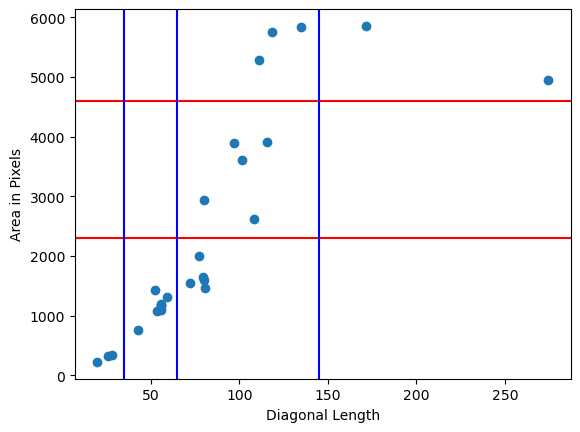

In [8]:
# size grouping determination graph block: in this block I create a scatterplot of the relationship 
# between area and diagonal length, then I created lines that appear to seperate these points into 
# sections that seem to be grouped together. I will label the points in each filled section with a unique label

plt.scatter(np_points[:,0], np_points[:,1])
plt.axhline(y = 4600, color = 'r', linestyle = '-')
plt.axhline(y = 2300, color = 'r', linestyle = '-')
plt.axvline(x = 35, color = 'b', label = 'axvline - full height')
plt.axvline(x = 65, color = 'b', label = 'axvline - full height')
plt.axvline(x = 145, color = 'b', label = 'axvline - full height')
plt.xlabel("Diagonal Length")
plt.ylabel("Area in Pixels")
plt.show()

In [9]:
# the following two functions are used to determine whether the inputted building is 
# the largest or the smallest or neither

def isSmallest(raw_data, building_num):
    area = raw_data[building_num][3]
    diag = raw_data[building_num][6]
    input_combo = (area, diag)
    
    for key, val in raw_data.items():
        curr_combo = (val[3], val[6])
        if curr_combo < input_combo:
            return False
    
    return True
    
def isLargest(raw_data, building_num):
    area = raw_data[building_num][3]
    diag = raw_data[building_num][6]
    input_combo = (area, diag)
    
    for key, val in raw_data.items():
        curr_combo = (val[3], val[6])
        if curr_combo > input_combo:
            return False
    
    return True

# the following 3 labels derived from the graph above will be used to identify
# sizes distinctly in the function below.
    # Minuscule: the group with the smallest area and diagonal length will
    # Tiny: the group to the right (on the graph) of the Minuscule group
    # Small: the group to the right of the Tiny group
    # Medium: the middle group on the graph
    # Large: the upper middle group on the graph
    # Gigantic: the upper right group containing the points with the largest area and diagonal length
    
def size_(raw_data, building_num):
    # input: raw_data and building number
    # task: uses magic numbers derived from the graph above to label the size of the inputted building
    # output: string labeling the size of the input building
    
    area = raw_data[building_num][3]
    diag = raw_data[building_num][6]
    
#     if area < 2300:
#         return 'Small'
    
#     if area < 4600:
#         return 'Medium'
    
#     return 'Large'
    
    if isSmallest(raw_data, building_num):
        return 'Smallest'
    
    if isLargest(raw_data, building_num):
        return 'Largest'
    
    # Minuscule:
    if diag < 35 and area < 2300:
        return 'Minuscule'
    
    # Tiny
    if diag < 65 and area < 2300:
        return 'Tiny'
    
    # Small
    if diag < 145 and area < 2300:
        return 'Small'
    
    # Medium
    if diag < 145 and area < 4600:
        return 'Medium'
    
    # Large
    if diag < 145:
        return 'Large'
    
    # Gigantic
    return 'Gigantic'

# testing the above size functions:
for key, val in raw_data.items():
    print(val[0], size_(raw_data, key))


Pupin Small
SchapiroCEPSR Tiny
Mudd&EngTerrace&Fairchild&CS Large
NorthwestCorner Small
Uris Large
Schermerhorn Medium
Chandler&Havemeyer Medium
OldComputerCenter Minuscule
Avery Tiny
Fayerweather Tiny
Mathematics Tiny
LowLibrary Medium
StPaulChapel Tiny
EarlHall Tiny
Lewisohn Tiny
Philosophy Tiny
Buell Minuscule
AlmaMater Smallest
Dodge Small
Kent Small
CollegeWalk Gigantic
Journalism&Furnald Medium
Hamilton&Hartley&Wallach&JohnJay Largest
Lerner Medium
ButlerLibrary Large
Carman Small


In [10]:
# the following few code blocks are used to determine the magic numbers used for the aspect ratio shape functions

# in this block I display area, diagonal length, name tuples sorted from largest area to least
aspect_list = list()
for key, val in raw_data.items():
    name, layer, com, area, ul, lr, diag, overlap = val
    
    width = lr[0] - ul[0]
    height = lr[1] - ul[1]
    
    aspect_list.append([round(width/height,1), width, height, name])
    
aspect_list.sort()

print('W/H', 'W ', 'H ', 'Name')
aspect_points = list()
for x in aspect_list:
    print(x[0], x[1], x[2], x[3])
    aspect_points.append([x[1], x[2]])
np_aspect_points = np.array(aspect_points)



W/H W  H  Name
0.4 26 73 NorthwestCorner
0.5 24 50 Avery
0.5 25 50 Fayerweather
0.5 28 52 Lewisohn
0.5 79 152 Hamilton&Hartley&Wallach&JohnJay
0.6 13 22 OldComputerCenter
0.6 27 46 Philosophy
0.6 28 48 Mathematics
0.7 65 99 Uris
1.0 14 14 AlmaMater
1.0 68 69 LowLibrary
1.0 77 76 Journalism&Furnald
1.2 40 34 SchapiroCEPSR
1.2 77 66 Chandler&Havemeyer
1.3 92 70 Schermerhorn
1.3 106 83 Mudd&EngTerrace&Fairchild&CS
1.6 24 15 Buell
1.6 94 59 ButlerLibrary
1.7 37 22 EarlHall
1.7 69 41 Lerner
2.1 50 24 StPaulChapel
3.2 76 24 Pupin
3.3 69 21 Carman
3.5 77 22 Dodge
3.9 78 20 Kent
16.1 274 17 CollegeWalk


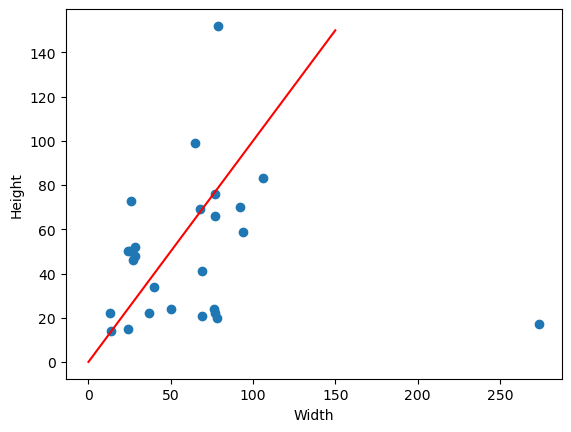

In [11]:
# plotting relationship between building width and height to see if any clusters arrise

plt.scatter(np_aspect_points[:,0], np_aspect_points[:,1])
x = np.linspace(0,150)
y = x
plt.plot(x,y, color = 'r')
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

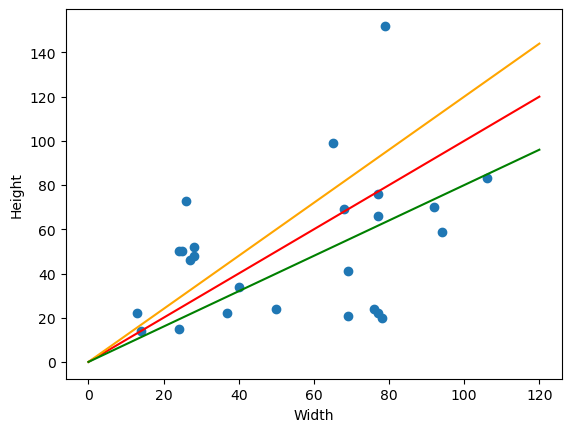

In [12]:
# constructing a plot without the outlier of college walk to see more clearly if any clusters arrise:
#plt.scatter(np_aspect_points[:,0], np_aspect_points[:,1])
plt.scatter(np_aspect_points[:len(np_aspect_points)-1,0], np_aspect_points[:len(np_aspect_points)-1,1])
x = np.linspace(0,120)
y = x
plt.plot(x,y, color = 'r')
y2 = 1.2*x  #x + 15
y3 = 0.8*x   #x - 20
plt.plot(x,y2, color = 'orange')
plt.plot(x,y3, color = 'g')
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [13]:
# ASPECT RATIO

# the following two functions use the width:height ratio of the buildings to determine whether
# the inputted building is the narrowest or widest or neither

def isNarrowest(raw_data, building_num):
    ul = raw_data[building_num][4]
    lr = raw_data[building_num][5]
    width = lr[0] - ul[0]
    height = lr[1] - ul[1]
    ratio = round(width/height,1)
    
    for key, val in raw_data.items():
        ul2 = val[4]
        lr2 = val[5]
        width2 = lr2[0] - ul2[0]
        height2 = lr2[1] - ul2[1]
        ratio2 = round(width2/height2,1)
        if ratio2 < ratio:
            return False
        
    return True

def isWidest(raw_data, building_num):
    ul = raw_data[building_num][4]
    lr = raw_data[building_num][5]
    width = lr[0] - ul[0]
    height = lr[1] - ul[1]
    ratio = round(width/height,1)
    
    for key, val in raw_data.items():
        ul2 = val[4]
        lr2 = val[5]
        width2 = lr2[0] - ul2[0]
        height2 = lr2[1] - ul2[1]
        ratio2 = round(width2/height2,1)
        if ratio2 > ratio:
            return False
        
    return True

# the following function uses the magic numbers determined from the above graphs to label
# a building as either Narrow, Wide, or Medium-Width
def aspectRatio(raw_data, building_num):
    # input: raw_data and building number
    # output: string labeling the aspectRatio of the inputted building
    
    ul = raw_data[building_num][4]
    lr = raw_data[building_num][5]
    width = lr[0] - ul[0]
    height = lr[1] - ul[1]
    ratio = round(width/height,1)
    #print(ratio)
    
    if isNarrowest(raw_data, building_num):
        return 'Narrowest'
    
    if isWidest(raw_data, building_num):
        return 'Widest'
    
    if ratio < 0.8:
        return 'Narrow'
    
    if ratio > 1.2:
        return 'Wide'
    
    return 'Medium-Width'

# testing the above aspect ratio functions:
for key, val in raw_data.items():
    print(val[0], aspectRatio(raw_data, key))
    

Pupin Wide
SchapiroCEPSR Medium-Width
Mudd&EngTerrace&Fairchild&CS Wide
NorthwestCorner Narrowest
Uris Narrow
Schermerhorn Wide
Chandler&Havemeyer Medium-Width
OldComputerCenter Narrow
Avery Narrow
Fayerweather Narrow
Mathematics Narrow
LowLibrary Medium-Width
StPaulChapel Wide
EarlHall Wide
Lewisohn Narrow
Philosophy Narrow
Buell Wide
AlmaMater Medium-Width
Dodge Wide
Kent Wide
CollegeWalk Widest
Journalism&Furnald Medium-Width
Hamilton&Hartley&Wallach&JohnJay Narrow
Lerner Wide
ButlerLibrary Wide
Carman Wide


In [14]:
# GEOMETRY

def x_sym_score(mbr):
    # input: - mbr: 2D array depicting the splice of the total
    #               image that is contained within the mbr of the input building
    #        - area of building
    # return: percentage of symmetry
    
    tot = 0
    area = len(mbr) * len(mbr[0])
    
    for row in range(len(mbr)):
        for col in range(len(mbr[0])//2):        
            if mbr[row,col] == mbr[row,len(mbr[0]) - col - 1]:
                tot += 1
    
    if len(mbr[0]) % 2 == 1:
        area = (area - len(mbr)) / 2 # area minus middle col
    else:
        area = area / 2
    return tot / area

def y_sym_score(mbr):
    # same as x_sym_score except it checks for vertical symetry not horizontal
    
    area = len(mbr) * len(mbr[0])
    tot = 0
    for col in range(len(mbr[0])):
        for row in range(len(mbr)//2):
            if mbr[row,col] == mbr[len(mbr)-row-1,col]:
                tot += 1
                
    if len(mbr) % 2 == 1:
        area = (area - len(mbr[0])) / 2 # area minus middle row
    else:
        area = area / 2
                
    return tot / area

# the outputted table will help give a sense of what a good symmetry score is as I will compare the returned
# percentages with the actual building shapes
# -> particularly, buildings like Low, Butler, and Uris should reflect high horizontal symmtery scores 
#    while Havermeyer for example should reflect a relatively low score

# n = 9 #255 #113 #9 #246
    
print("{:<32} {:<6} {:<6}"
          .format('NAME', 'X SYM', 'Y SYM'))

for key, val in raw_data.items():
    ul = val[4]
    lr = val[5]
    layer = val[1]
    name = val[0]
    
    mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
    
    print("{:<32} {:<6} {:<6}" .format(name, round(x_sym_score(mbr),2), 
                                       round(y_sym_score(mbr),2)))
    

NAME                             X SYM  Y SYM 
Pupin                            0.92   0.78  
SchapiroCEPSR                    1.0    1.0   
Mudd&EngTerrace&Fairchild&CS     0.58   0.47  
NorthwestCorner                  1.0    1.0   
Uris                             0.98   0.91  
Schermerhorn                     0.7    0.42  
Chandler&Havemeyer               0.71   0.55  
OldComputerCenter                1.0    1.0   
Avery                            0.82   1.0   
Fayerweather                     0.95   0.99  
Mathematics                      0.97   0.99  
LowLibrary                       0.99   0.99  
StPaulChapel                     0.86   0.96  
EarlHall                         0.97   0.99  
Lewisohn                         0.97   0.99  
Philosophy                       1.0    0.98  
Buell                            0.97   0.95  
AlmaMater                        1.0    1.0   
Dodge                            0.99   0.76  
Kent                             0.99   0.76  
CollegeWalk  

In [357]:
# buildings to me that seem vertically symmetrical (fold top over bottom)
# Noco, shapiro, old computer center, Fayerweather, mathematics, low, st paul chapel, earl,
# lewison, phiosophy, alma mater, college walk, buell, lerner, butler, carman, avery
# the minimum y-sym symmtery score of all of these is: 0.95

# buildings to me that seem horizontally symmetrical (fold left over right)
# noco, shapiro, computer center, buell, low, alma mater, earl, dodge, kent, college walk,
# lerner, butler, carmen
# kind of: uris, fayerweather, math, philosophy
# minimum x-sym symmetry score of all of these is: 0.95 (including ones that are not
# perfectly symetrical but are considered by me to be close enough)


# the magic numbers of 0.95 in the following two functions were determined from the 
# observations from the previous two code cells
    
def isRectangle(br):
    # returns boolean stating whether or not the building is considered rectangular
    # (meaning it is symmetrical in x and in y)
    
#     val = raw_data[building_num]
#     ul = val[4]
#     lr = val[5]
#     layer = val[1]
#     mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
    
    return (x_sym_score(br) >= 0.95 and y_sym_score(br) >= 0.95)

def isSquare(br):
    # returns boolean stating whether or not the building is considered square-shaped
    # (meaning it is symmtrical in x and in y)
    
#     val = raw_data[building_num]
#     ul = val[4]
#     lr = val[5]   
#    height = lr[1] - ul[1]
#     width = lr[0] - ul[0]
    
    height = br.shape[0]
    width = br.shape[1]
    
    # the only buildings I count as being square are low library, alma mater,
    # and Shapiro: their height / width values are the following, respectively:
    # 1.015, 1.0, and 0.85
    # because of these values I will define square as having a height:width ratio
    # that is within 0.15 of 1, inclusive
        
    ratio = height/width
    return isRectangle(mbr) and (ratio >= 0.85 and ratio <= 1.15)

print("{:<32} {:<6} {:<6}"
          .format('NAME', 'SQUARE', 'RECT'))

for key, val in raw_data.items():
    val = raw_data[key]
    ul = val[4]
    lr = val[5]
    layer = val[1]
    mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
    
    squ = isSquare(mbr)
    rect = isRectangle(mbr)
    name = val[0]
    
    print("{:<32} {:<6} {:<6}" .format(name, str(squ), str(rect)))

NAME                             SQUARE RECT  
Pupin                            False  False 
SchapiroCEPSR                    True   True  
Mudd&EngTerrace&Fairchild&CS     False  False 
NorthwestCorner                  False  True  
Uris                             False  False 
Schermerhorn                     False  False 
Chandler&Havemeyer               False  False 
OldComputerCenter                False  True  
Avery                            False  False 
Fayerweather                     False  True  
Mathematics                      False  True  
LowLibrary                       True   True  
StPaulChapel                     False  False 
EarlHall                         False  True  
Lewisohn                         False  True  
Philosophy                       False  True  
Buell                            False  False 
AlmaMater                        True   True  
Dodge                            False  False 
Kent                             False  False 
CollegeWalk  

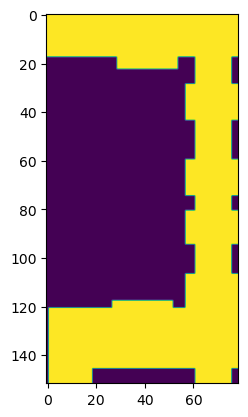

In [64]:
def foldVert(binary_shape): # folds bottom of inputted 2d np binary array over the top over the center row
    width = binary_shape.shape[1]
    height = binary_shape.shape[0]
    res = np.zeros((height//2, width))
    for row in range(height//2):
        for col in range(width):
            if binary_shape[row,col] == 1 or binary_shape[height-row-1, col] == 1:
                res[row, col] = 1
                
    return res

def foldHoriz(binary_shape): # folds bottom of inputted 2d np binary array over the top over the center row
    width = binary_shape.shape[1]
    height = binary_shape.shape[0]
    res = np.zeros((height, width//2))
    for row in range(height):
        for col in range(width//2):
            if binary_shape[row,col] == 1 or binary_shape[row, width-col-1] == 1:
                res[row, col] = 1
                
    return res

val = raw_data[217]
ul = val[4]
lr = val[5]
layer = val[1]
mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
plt.imshow(mbr)


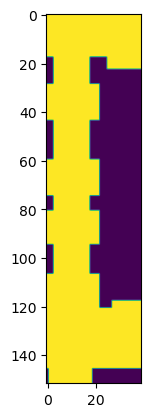

In [65]:
plt.imshow(foldHoriz(mbr))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


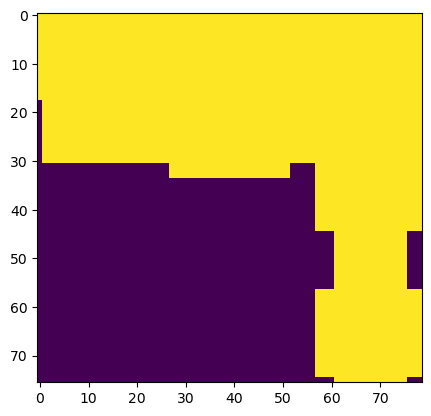

In [72]:
plt.imshow(foldVert(mbr))

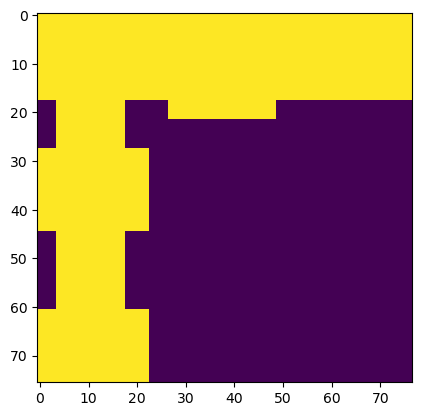

In [432]:
# the following three code blocks were used to determine how to fold building
# MBR's over both diagonals
# -> these folding operations are used to determine the overlap that results from 
    # the folding -> ulitmately high overlap over one corner and low overlap in the other
    # while the input building is definately not a square or rectangle means that 
    # the building must be L-shaped

val = raw_data[208] # L-shaped: 66, 208 #uris 47 #179 dodge
ul = val[4]
lr = val[5]
layer = val[1]
mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
#mbr = foldVert(mbr)
#mbr = foldHoriz(mbr)

plt.imshow(mbr)

0.83


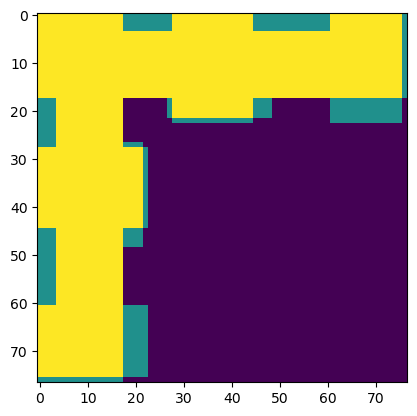

In [433]:
t = mbr.T

new_shape = np.zeros((max(t.shape[0], mbr.shape[0]), max(t.shape[1], mbr.shape[1])))
#new_shape = np.zeros(max(t.shape, mbr.shape))
for row in range(new_shape.shape[0]):
    for col in range(new_shape.shape[1]):
        if row < t.shape[0] and col < t.shape[1]:
            if t[row,col] == 1:
                new_shape[row, col] += 1
        if row < mbr.shape[0] and col < mbr.shape[1]:
            if mbr[row, col] == 1:
                new_shape[row, col] += 1
                
plt.imshow(new_shape)
print(overlap_qual(new_shape))

0.16


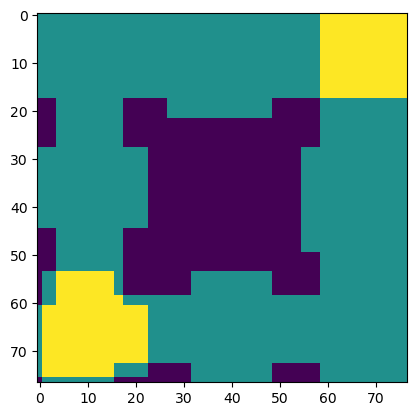

In [434]:
t2 = np.flip(mbr).T
new_shape2 = np.zeros((max(t2.shape[0], mbr.shape[0]), max(t2.shape[1], mbr.shape[1])))
x_shift = max(t2.shape[1], mbr.shape[1]) - min(t2.shape[1], mbr.shape[1])
#y_shift = max(t2.shape[0], mbr.shape[0]) - min(t2.shape[0], mbr.shape[0])
#print(y_shift+t2.shape[])

for row in range(new_shape2.shape[0]):
    for col in range(new_shape2.shape[1]):
        
        if row < t2.shape[0] and col < t2.shape[1]:
            if t2[row,col] == 1:# and col+x_shift < new_shape2.shape[1]:
                if mbr.shape[1] > mbr.shape[0]:
                    new_shape2[row, col+x_shift] += 1
                else:
                    new_shape2[row, col] += 1
                
        if row < mbr.shape[0] and col < mbr.shape[1]:
            if mbr[row, col] == 1:
                if mbr.shape[0] > mbr.shape[1]:
                    new_shape2[row, col+x_shift] += 1
                else:
                    new_shape2[row, col] += 1
                
plt.imshow(new_shape2)
print(overlap_qual(new_shape2))

In [420]:
def flipDiag1(br):
    t = br.T
    new_shape = np.zeros((max(t.shape[0], br.shape[0]), max(t.shape[1], br.shape[1])))
    for row in range(new_shape.shape[0]):
        for col in range(new_shape.shape[1]):
            if row < t.shape[0] and col < t.shape[1]:
                if t[row,col] == 1:
                    new_shape[row, col] += 1
            if row < br.shape[0] and col < br.shape[1]:
                if br[row, col] == 1:
                    new_shape[row, col] += 1

    return new_shape

def flipDiag2(br):
    t2 = np.flip(br).T
    new_shape2 = np.zeros((max(t2.shape[0], br.shape[0]), max(t2.shape[1], br.shape[1])))
    x_shift = max(t2.shape[1], br.shape[1]) - min(t2.shape[1], br.shape[1])

    for row in range(new_shape2.shape[0]):
        for col in range(new_shape2.shape[1]):
            if row < t2.shape[0] and col < t2.shape[1]:
                if t2[row,col] == 1:
                    if br.shape[1] > br.shape[0]:
                        new_shape2[row, col+x_shift] += 1
                    else:
                        new_shape2[row, col] += 1

            if row < br.shape[0] and col < br.shape[1]:
                if br[row, col] == 1:
                    if br.shape[0] > br.shape[1]:
                        new_shape2[row, col+x_shift] += 1
                    else:
                        new_shape2[row, col] += 1

    return new_shape2

def overlap_qual(br):
    tot_area = 0
    overlap_area = 0
    for row in range(br.shape[0]):
        for col in range(br.shape[1]):
            if br[row, col] == 2:
                overlap_area += 1
            if br[row, col] > 0:
                tot_area += 1
                
    return round(float(overlap_area) / (tot_area),2)

In [421]:
# this printed table will be used to determine the magic number of what percent overlap
# will determine the cut off for an L-shaped building

print("{:<37} {:<20} {:<20}"
          .format('NAME', 'Diag1 Overlap', 'Diag2 Overlap'))

for key, val in raw_data.items():
    val = raw_data[key]
    ul = val[4]
    lr = val[5]
    layer = val[1]
    mbr = layer[ul[1]:lr[1], ul[0]:lr[0]]
        
    oq1 = overlap_qual(flipDiag1(mbr))
    oq2 = overlap_qual(flipDiag2(mbr))
    
    if isSquare(mbr) or isRectangle(mbr):
        oq1 = 0
        oq2 = 0

    print("{:<37} {:<20} {:<20}" .format(val[0], oq1, oq2))
    
    #if val[0] in ['Lewisohn', 'Mathematics', 'Philosophy']:
    mbr2 = foldVert(foldHoriz(mbr))
    oq1 = overlap_qual(flipDiag1(mbr2))
    oq2 = overlap_qual(flipDiag2(mbr2))
    print("{:<37} {:<20} {:<20}" .format(val[0] + ' (2 fold)', oq1, oq2))
        
   # if val[0] == 'Hamilton&Hartley&Wallach&JohnJay':
    mbr3 = foldVert(mbr)
    oq1 = overlap_qual(flipDiag1(mbr3))
    oq2 = overlap_qual(flipDiag2(mbr3))
    print("{:<37} {:<20} {:<20}" .format(val[0] + ' (1 fold)', oq1, oq2))
        

NAME                                  Diag1 Overlap        Diag2 Overlap       
Pupin                                 0.17                 0.14                
Pupin (2 fold)                        0.19                 0.19                
Pupin (1 fold)                        0.09                 0.07                
SchapiroCEPSR                         0                    0                   
SchapiroCEPSR (2 fold)                0.74                 0.74                
SchapiroCEPSR (1 fold)                0.27                 0.27                
Mudd&EngTerrace&Fairchild&CS          0.26                 0.47                
Mudd&EngTerrace&Fairchild&CS (2 fold) 0.63                 0.63                
Mudd&EngTerrace&Fairchild&CS (1 fold) 0.17                 0.27                
NorthwestCorner                       0                    0                   
NorthwestCorner (2 fold)              0.22                 0.22                
NorthwestCorner (1 fold)              0.

In [403]:
def isLShaped2(br):
    if isSquare(br) or isRectangle(br):
        return False
    
    d1 = flipDiag1(br)
    d2 = flipDiag2(br)
    
    # for the 2-fold I-shaped buildings:
    if overlap_qual(d1) >= 0.44 and overlap_qual(d1) >= 0.44:
        return True
    
    L_overlap = 0.69
    if (overlap_qual(d1) >= L_overlap and 
        overlap_qual(d2) < L_overlap) or (overlap_qual(d2) >= L_overlap and overlap_qual(d1) < L_overlap):
        return True
    
    return False
    

In [416]:
def isCShaped(br):
    horiz = foldHoriz(br)
    vert = foldVert(br)
    if isLShaped2(horiz) or isLShaped2(vert):
        return True
    return False
        
def isIShaped(br):
    horiz = foldHoriz(br)
    vert = foldVert(br)
    if isCShaped(horiz) or isCShaped(vert):
        return True
    return False
    
def geometry(raw_data, building_num):
    
    val = raw_data[building_num]
    ul = val[4]
    lr = val[5]
    layer = val[1]
    mbr_ = layer[ul[1]:lr[1], ul[0]:lr[0]]
    #plt.imshow(mbr_)
    
    if isSquare(mbr_):
        return "Square-shaped"
    if isRectangle(mbr_):
        
        if isIShaped(mbr_):
            return "I-shaped"
        
        return "Rectangle-shaped"
    
    if isLShaped(mbr_):
        return "L-shaped"
    if isCShaped(mbr_) and ():
        return "C-shaped"
    
    return "Asymmetrical"
    

In [417]:
# creating table using the above shape labeling functions

print("{:<32} {:<12} {:<14} {:<10}"
          .format('NAME', 'SIZE', 'ASPECT RATIO', 'GEOMETRY'))

for key, val in raw_data.items():
    print("{:<32} {:<12} {:<14} {:<10}" .format(str(val[0]), size_(raw_data, key),
                  aspectRatio(raw_data, key), geometry(raw_data, key)))
    

NAME                             SIZE         ASPECT RATIO   GEOMETRY  
Pupin                            Small        Wide           Asymmetrical
SchapiroCEPSR                    Tiny         Medium-Width   Square-shaped
Mudd&EngTerrace&Fairchild&CS     Large        Wide           C-shaped  
NorthwestCorner                  Small        Narrowest      Rectangle-shaped
Uris                             Large        Narrow         C-shaped  
Schermerhorn                     Medium       Wide           Asymmetrical
Chandler&Havemeyer               Medium       Medium-Width   Square-shaped
OldComputerCenter                Minuscule    Narrow         Rectangle-shaped
Avery                            Tiny         Narrow         Asymmetrical
Fayerweather                     Tiny         Narrow         Rectangle-shaped
Mathematics                      Tiny         Narrow         I-shaped  
LowLibrary                       Medium       Medium-Width   Square-shaped
StPaulChapel                   

In [ ]:
# --------------------------------------------------------------------------------------
# STEP 3 -  ABSOLUTE LOCATION
# --------------------------------------------------------------------------------------

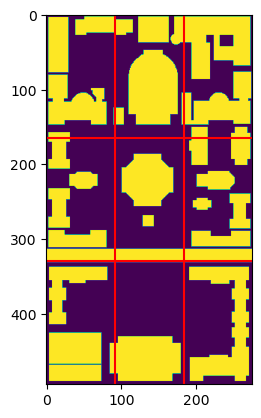

In [34]:
# Creating Numpy Array from 'Campus.pgm' file to determine the absolute location boundaries of buildings
campus_file = Image.open('Desktop/vis_int_hw3/Campus.pgm')
campus_arr = np.asarray(campus_file)
tot_height,tot_width = campus_arr.shape
plt.axhline(y = tot_height/3, color = 'r', linestyle = '-')
plt.axhline(y = 2*tot_height/3, color = 'r', linestyle = '-')
plt.axvline(x = tot_width/3, color = 'r', label = 'axvline - full height')
plt.axvline(x = 2*tot_width/3, color = 'r', label = 'axvline - full height')
plt.imshow(campus_arr)


In [35]:
# Next I will use the above grid and the COM of each of the buildings to construct functions that 
# will labeled where buildings are vertically and horizontally in space as well as labeling the
# orientation of the building

# the following two functions determine whether the input building is the uppermost or lowermost building or neither
def isUppermost(raw_data, num):
    com_y = raw_data[num][2][1]
    for key, val in raw_data.items():
        if val[2][1] < com_y:
            return False
    return True

def isLowermost(raw_data, num):
    com_y = raw_data[num][2][1]
    for key, val in raw_data.items():
        if val[2][1] > com_y:
            return False
    return True

# the following function labels the vertical absolute location of the input building using the following
# labels: 'Uppermost', 'Upper', 'Mid-Height', 'Lower', 'Lowermost'
def vertical_location(raw_data, num, tot_height):
    com_y = raw_data[num][2][1]
    
    if isUppermost(raw_data, num):
        return 'Uppermost'
    if isLowermost(raw_data, num):
        return 'Lowermost'
    
    if com_y < tot_height/3:
        return 'Upper'
    
    if com_y < 2*tot_height/3:
        return 'Mid-Height'
    
    return 'Lower'

# the following two functions determine whether the input building is the leftmost or rightmost building or neither
def isLeftmost(raw_data, num):
    com_x = raw_data[num][2][0]
    for key, val in raw_data.items():
        if val[2][0] < com_x:
            return False
    return True

def isRightmost(raw_data, num):
    com_x = raw_data[num][2][0]
    for key, val in raw_data.items():
        if val[2][0] > com_x:
            return False
    return True

# the following function labels the horizontal absolute location of the input building using the following
# labels: 'Leftmost', 'Left', 'Mid-Width', 'Right', 'Rightmost'
def horizontal_location(raw_data, num, tot_width):
    com_x = raw_data[num][2][0]
    
    if isLeftmost(raw_data, num):
        return 'Leftmost'
    if isRightmost(raw_data, num):
        return 'Rightmost'
    
    if com_x < tot_width/3:
        return 'Left'
    
    if com_x < 2*tot_width/3:
        return 'Mid-Width'
    
    return 'Right'

# the following function labels the orientation of the input building based on which dimention, height or width,
# of the building is larger than the other
# (Note: the differentiation between this function and the aspect ratio function is that the aspect ratio function
# has more leeway in deciding whether a building is Medium-wide, while in the following orientation function,
# the only way 'Non-oriented' is returned as a label is if building width is exactly equal to building height)
def orientation(raw_data, num):
    ul = raw_data[num][4]
    lr = raw_data[num][5]
    w = lr[0] - ul[0]
    h = lr[1] - ul[1]
    if w == h:
        return 'Non-Oriented'
    
    if w < h:
        return 'Vertically-Oriented'
    
    return 'Horizontally-Oriented'

# creating tabling using the above absolute location functions
# also creating a dictionary that stores a tuple of (vertical location, horizontal location, and orientation)
# as its keys, with its values being a corresponding list of the buildings that identify with these attributes

abs_loc_confusion = dict()

print("{:<32} {:<12} {:<14} {:<10}"
          .format('NAME', 'VERTICALLY', 'HORIZONTALLY', 'ORIENTED'))

for key, val in raw_data.items():
    vloc = vertical_location(raw_data, key, tot_height)
    hloc = horizontal_location(raw_data, key, tot_width)
    ori = orientation(raw_data, key)
    print("{:<32} {:<12} {:<14} {:<10}" .format(str(val[0]), vloc, hloc, ori))
    
    abs_loc = (vloc, hloc, ori)
    if abs_loc in abs_loc_confusion.keys():
        abs_loc_confusion[abs_loc].append(val[0])
    else:
        abs_loc_confusion[abs_loc] = [val[0]]
          

NAME                             VERTICALLY   HORIZONTALLY   ORIENTED  
Pupin                            Uppermost    Left           Horizontally-Oriented
SchapiroCEPSR                    Upper        Mid-Width      Horizontally-Oriented
Mudd&EngTerrace&Fairchild&CS     Upper        Right          Horizontally-Oriented
NorthwestCorner                  Upper        Leftmost       Vertically-Oriented
Uris                             Upper        Mid-Width      Vertically-Oriented
Schermerhorn                     Upper        Right          Horizontally-Oriented
Chandler&Havemeyer               Upper        Left           Horizontally-Oriented
OldComputerCenter                Upper        Mid-Width      Vertically-Oriented
Avery                            Mid-Height   Right          Vertically-Oriented
Fayerweather                     Mid-Height   Rightmost      Vertically-Oriented
Mathematics                      Mid-Height   Left           Vertically-Oriented
LowLibrary                 

In [36]:
# printing final table for absolute location step:

print("{:<32} {:<12} {:<14} {:<23} {:<10}"
          .format('NAME', 'VERTICALLY', 'HORIZONTALLY', 'ORIENTED', 'CONFUSION'))

# for key, val in raw_data.items():
#     vloc = vertical_location(raw_data, key, tot_height)
#     hloc = horizontal_location(raw_data, key, tot_width)
#     ori = orientation(raw_data, key)
#     print("{:<32} {:<12} {:<14} {:<10}" .format(str(val[0]), vloc, hloc, ori))
    
#     abs_loc = (vloc, hloc, ori)
#     if abs_loc in abs_loc_confusion.keys():
#         abs_loc_confusion[abs_loc].append(val[0])
#     else:
#         abs_loc_confusion[abs_loc] = [val[0]]

for key, val in raw_data.items():
    vloc = vertical_location(raw_data, key, tot_height)
    hloc = horizontal_location(raw_data, key, tot_width)
    ori = orientation(raw_data, key)
    print("{:<32} {:<12} {:<14} {:<23}" .format(str(val[0]), vloc, hloc, ori), end=" ")
    if len(abs_loc_confusion[(vloc, hloc, ori)]) > 1:
        for x in abs_loc_confusion[(vloc, hloc, ori)]:
            if x != val[0]:
                print(x, end=" ")
    print()

NAME                             VERTICALLY   HORIZONTALLY   ORIENTED                CONFUSION 
Pupin                            Uppermost    Left           Horizontally-Oriented   
SchapiroCEPSR                    Upper        Mid-Width      Horizontally-Oriented   
Mudd&EngTerrace&Fairchild&CS     Upper        Right          Horizontally-Oriented   Schermerhorn 
NorthwestCorner                  Upper        Leftmost       Vertically-Oriented     
Uris                             Upper        Mid-Width      Vertically-Oriented     OldComputerCenter 
Schermerhorn                     Upper        Right          Horizontally-Oriented   Mudd&EngTerrace&Fairchild&CS 
Chandler&Havemeyer               Upper        Left           Horizontally-Oriented   
OldComputerCenter                Upper        Mid-Width      Vertically-Oriented     Uris 
Avery                            Mid-Height   Right          Vertically-Oriented     Philosophy 
Fayerweather                     Mid-Height   Rightmos

In [37]:
# --------------------------------------------------------------------------------------
# STEP 4 -  RELATIVE SPACE
# --------------------------------------------------------------------------------------

In [38]:
# the following function determines the new mbr of a building whose dimensions are twice the size of the
# original mbr: this function is used to determine what buildings are nearby the inputted building as
# building's whose original mbr's intersect with the target building's new mbr are considered near the 
# target image
def determine_nearby_mbr(raw_data, building_num):
    val = raw_data[building_num]
    x1 = val[4][0]
    x2 = val[5][0]
    y1 = val[4][1]
    y2 = val[5][1]
    w = x2 - x1
    h = y2 - y1
    #layer = val[1]
    
    # noting that the shape of the entire image is: (495, 275)
    
    if x1 - w/2 >= 0:
        x1 = x1 - w//2
    else:
        x1 = 0
        
    if x2 + w/2 < 275:
        x2 = x2 + w//2
    else:
        x2 = 274
        
    if y1 - h/2 >= 0:
        y1 = y1 - h//2
    else:
        y1 = 0
        
    if y2 + h/2 < 495:
        y2 = y2 + h//2
    else:
        y2 = 494
    
    #mbr = layer[y1:y2, x1:x2]
    return x1, x2, y1, y2

def intersecting_mbrs(mbr1_ul, mbr1_lr, mbr2_ul, mbr2_lr):
    
    intersects = True
    
    # If one rectangle is on left side of other
    if mbr1_ul[0] >= mbr2_lr[0] or mbr2_ul[0] >= mbr1_lr[0]:
#         print('1')
#         print(mbr1_ul[0], mbr2_lr[0])
#         print(mbr2_ul[0], mbr1_lr[0])
        intersects = False

    # If one rectangle is above other
    if mbr1_lr[1] <= mbr2_ul[1] or mbr2_lr[1] <= mbr1_ul[1]:
#         print('2')
#         print(mbr1_lr[1], mbr2_ul[1])
#         print(mbr2_lr[1], mbr1_ul[1])
        intersects = False
        
    return intersects

def nearTo(raw_data, S_num, T_num):
    x1, x2, y1, y2 = determine_nearby_mbr(raw_data, S_num)
    S_mbr_ul = (x1,y1)
    S_mbr_lr = (x2,y2)
    
    T = raw_data[T_num]
    T_mbr_ul = T[4]
    T_mbr_lr = T[5]
    
    return intersecting_mbrs(S_mbr_ul, S_mbr_lr, T_mbr_ul, T_mbr_lr)

n1 = 189
n2 = 217

print(raw_data[n1][0], raw_data[n2][0])

ul2 = raw_data[n2][4]
lr2 = raw_data[n2][5]

x1, x2, y1, y2 = determine_nearby_mbr(raw_data, n1)

print(ul2[0],lr2[0],ul2[1],lr2[1])
print(x1,x2,y1,y2)

print(intersecting_mbrs((x1,y1), (x2,y2), ul2, lr2))
print(intersecting_mbrs(ul2, lr2, (x1,y1), (x2,y2)))


Kent Hamilton&Hartley&Wallach&JohnJay
191 270 338 490
155 274 280 320
False
False


67 203 153 290


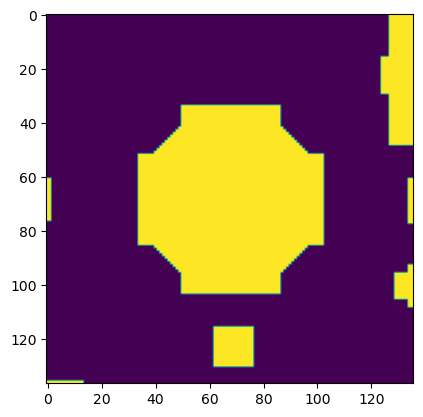

In [39]:
n = 113
x1, x2, y1, y2 = determine_nearby_mbr(raw_data, n)
#layer = raw_data[n][1]
#plt.imshow(layer[y1:y2, x1:x2])
print(x1,x2,y1,y2)
plt.imshow(campus_arr[y1:y2, x1:x2])

In [40]:
near_sources_to_targets = dict() # keys are source buildings, values are target buildings near to the 
                                    # source building
near_targets_to_sources = dict() # keys are target buildings, values are source buildings near to 
                                    # the target building
for building1 in raw_data.keys():
    for building2 in raw_data.keys():
        if building1 == building2:
            continue
            
        if nearTo(raw_data, building1, building2):
            if raw_data[building1][0] in near_sources_to_targets.keys():
                near_sources_to_targets[raw_data[building1][0]].append(raw_data[building2][0])
            else:
                near_sources_to_targets[raw_data[building1][0]] = [raw_data[building2][0]]
                
        if nearTo(raw_data, building2, building1):
            if raw_data[building1][0] in near_targets_to_sources.keys():
                near_targets_to_sources[raw_data[building1][0]].append(raw_data[building2][0])
            else:
                near_targets_to_sources[raw_data[building1][0]] = [raw_data[building2][0]]
            
for k, v in raw_data.items():
    print(v[0])
    print('S to T: ', end = "")
    if v[0] in near_sources_to_targets.keys():
        for x in near_sources_to_targets[v[0]]:
            print(x, end = " ")
    print()
    print('T to S: ', end = "")
    if v[0] in near_targets_to_sources.keys():
        for x in near_targets_to_sources[v[0]]:
            print(x, end = " ")
    print()
    print()

Pupin
S to T: SchapiroCEPSR NorthwestCorner 
T to S: SchapiroCEPSR Mudd&EngTerrace&Fairchild&CS NorthwestCorner Uris 

SchapiroCEPSR
S to T: Pupin Mudd&EngTerrace&Fairchild&CS Uris 
T to S: Pupin Mudd&EngTerrace&Fairchild&CS Uris 

Mudd&EngTerrace&Fairchild&CS
S to T: Pupin SchapiroCEPSR Uris Schermerhorn 
T to S: SchapiroCEPSR Uris Schermerhorn 

NorthwestCorner
S to T: Pupin Chandler&Havemeyer 
T to S: Pupin Chandler&Havemeyer 

Uris
S to T: Pupin SchapiroCEPSR Mudd&EngTerrace&Fairchild&CS Schermerhorn Chandler&Havemeyer OldComputerCenter Avery LowLibrary 
T to S: SchapiroCEPSR Mudd&EngTerrace&Fairchild&CS Schermerhorn Chandler&Havemeyer 

Schermerhorn
S to T: Mudd&EngTerrace&Fairchild&CS Uris Avery Fayerweather 
T to S: Mudd&EngTerrace&Fairchild&CS Uris Avery Fayerweather 

Chandler&Havemeyer
S to T: NorthwestCorner Uris OldComputerCenter Mathematics 
T to S: NorthwestCorner Uris Mathematics 

OldComputerCenter
S to T: 
T to S: Uris Chandler&Havemeyer 

Avery
S to T: Schermerhorn St

In [41]:
# the following loop uses the near_targets_to_sources dictionary to sum, per source building, the total
# number of occurances that source building has as being a specific target building's source. Thus, 
# buildings with a higher corresponding integer are more prominant landmarks on the campus map

landmarks = dict()
for k, v in raw_data.items():
    name = v[0]
    if name in near_targets_to_sources.keys():
        for val in near_targets_to_sources[name]:
            #print(val)
            if val in landmarks.keys():
                landmarks[val] += 1
            else:
                landmarks[val] = 1

for k,v in landmarks.items():
    print(k, v)

SchapiroCEPSR 3
Mudd&EngTerrace&Fairchild&CS 4
NorthwestCorner 2
Uris 8
Pupin 2
Schermerhorn 4
Chandler&Havemeyer 4
Avery 2
Fayerweather 2
Mathematics 2
LowLibrary 6
StPaulChapel 3
EarlHall 2
Philosophy 2
Lewisohn 2
Dodge 2
Kent 2
Hamilton&Hartley&Wallach&JohnJay 4
CollegeWalk 4
Journalism&Furnald 4
Lerner 3
ButlerLibrary 4
Carman 2


In [42]:
# the following code block prints each building as a target on the left with its landmark source on the 
# right (its source that is the source most often used as a source for other buildings also)

def get_num(raw_data, building_name):
    # takes in building name and returns its number
    for k,v in raw_data.items():
        if v[0] == building_name:
            return k

build_land = dict()
print("{:<32} {:<12}" .format('TARGET', 'LANDMARK'))

for key, val in raw_data.items():
    k = val[0]
    if k in near_targets_to_sources.keys():
        v = near_targets_to_sources[k]
        maxi = 0
        maxi_build = 'Carman'

        for x in v:
            if landmarks[x] > maxi:
                maxi = landmarks[x]
                maxi_build = x

        build_land[key] = get_num(raw_data, maxi_build)
        print("{:<32} {:<12}" .format(k, maxi_build))
    else:
        print("{:<32} {:<12}" .format(k, 'None'))
    

TARGET                           LANDMARK    
Pupin                            Uris        
SchapiroCEPSR                    Uris        
Mudd&EngTerrace&Fairchild&CS     Uris        
NorthwestCorner                  Chandler&Havemeyer
Uris                             Mudd&EngTerrace&Fairchild&CS
Schermerhorn                     Uris        
Chandler&Havemeyer               Uris        
OldComputerCenter                Uris        
Avery                            Uris        
Fayerweather                     Schermerhorn
Mathematics                      Chandler&Havemeyer
LowLibrary                       Uris        
StPaulChapel                     LowLibrary  
EarlHall                         LowLibrary  
Lewisohn                         EarlHall    
Philosophy                       Hamilton&Hartley&Wallach&JohnJay
Buell                            LowLibrary  
AlmaMater                        LowLibrary  
Dodge                            LowLibrary  
Kent                            

In [43]:
# build land is a dictionary where the keys are the target buildings' numbers and the corresponding value
# is the number of the most prominent landmark to that target building

print(build_land)

{9: 47, 19: 47, 28: 47, 38: 66, 47: 28, 57: 47, 66: 47, 76: 47, 85: 47, 94: 57, 104: 66, 113: 47, 123: 113, 132: 113, 142: 132, 151: 217, 161: 113, 170: 113, 179: 113, 189: 198, 198: 208, 208: 198, 217: 198, 236: 208, 246: 208, 255: 246}


In [44]:
# --------------------------------------------------------------------------------------
# STEP 4 -  TOTAL DESCRIPTIONS
# --------------------------------------------------------------------------------------

In [424]:
def what_and_where(raw_data, building_num):
    si = size_(raw_data, building_num)
    ar = aspectRatio(raw_data, building_num)
    geo = geometry(raw_data, building_num)
    vloc = vertical_location(raw_data, building_num, tot_height)
    hloc = horizontal_location(raw_data, building_num, tot_width)
    ori = orientation(raw_data, building_num)
    
    all_info[raw_data[building_num][0]] = [si,ar,geo,vloc,hloc,ori]
     
    return "{} {} {} {} {} {} building".format(si,ar,geo,vloc,hloc,ori)

def description(raw_data, building_num):
    print("The " + what_and_where(raw_data, building_num), end = " ")
    print("near the " + what_and_where(raw_data, build_land[building_num]))
    
    
all_info = dict()
    
for key, val in raw_data.items():
    print(val[0] + " (near landmark {}):".format(raw_data[build_land[key]][0]))
    description(raw_data, key)
    print()


Pupin (near landmark Uris):
The Small Wide Asymmetrical Uppermost Left Horizontally-Oriented building near the Large Narrow C-shaped Upper Mid-Width Vertically-Oriented building

SchapiroCEPSR (near landmark Uris):
The Tiny Medium-Width Square-shaped Upper Mid-Width Horizontally-Oriented building near the Large Narrow C-shaped Upper Mid-Width Vertically-Oriented building

Mudd&EngTerrace&Fairchild&CS (near landmark Uris):
The Large Wide C-shaped Upper Right Horizontally-Oriented building near the Large Narrow C-shaped Upper Mid-Width Vertically-Oriented building

NorthwestCorner (near landmark Chandler&Havemeyer):
The Small Narrowest Rectangle-shaped Upper Leftmost Vertically-Oriented building near the Medium Medium-Width Square-shaped Upper Left Horizontally-Oriented building

Uris (near landmark Mudd&EngTerrace&Fairchild&CS):
The Large Narrow C-shaped Upper Mid-Width Vertically-Oriented building near the Large Wide C-shaped Upper Right Horizontally-Oriented building

Schermerhorn (ne

In [430]:
# the following code determines which buildings have all-description confusion

#all_confusion = dict()

for k1,v1 in all_info.items():
    for k2,v2 in all_info.items():
        if k1 == k2:
            continue
            
        if v1 == v2:
            print(k1, k2)
#             if k1 in all_confusion.keys():
#                 all_confusion[k1].append(k2)
#             else:
#                 all_confusion[k1] = [k2]
                
#             if k2 in all_confusion.keys():
#                 all_confusion[k2].append(k1)
#             else:
#                 all_confusion[k2] = [k1]
                
# for k,v in all_confusion.items():
#     print(k,v)

Mathematics Lewisohn
Lewisohn Mathematics


In [ ]:
# the following code block computes minimizations
